In [ ]:
import os

drive_project_path = r"/content/drive/MyDrive/Colab Notebooks/Project2/Project2Group3"
os.chdir(drive_project_path)

!pip install -r requirements.txt


import json
import pandas as pd
import holoviews as hv
import hvplot.pandas

from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
from datetime import datetime
from alpaca_trade_api.rest import REST, TimeFrame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from data_preparation import retreve_data_from_alpaca as rdfa

In [14]:
today = datetime.today().strftime('%Y-%m-%d')
dataBTCUSD2022today = rdfa("BTCUSD", TimeFrame.Hour, "2022-01-01", today)
dataETHUSD2022today = rdfa("ETHUSD", TimeFrame.Hour, "2022-01-01", today)

dataBTCUSD2022today.to_csv("./data/dataBTCUSD2022today.csv", index=None)
dataETHUSD2022today.to_csv("./data/dataETHUSD2022today.csv", index=None)

In [138]:
dataBTCUSD2018today = rdfa("BTCUSD", TimeFrame.Hour, "2018-01-01", today)

dataBTCUSD2018today.to_csv("./data/dataBTCUSD2018today.csv", index=None)

In [ ]:
# Create model object for BTCUSD
btcmodel = Prophet() 
btcmodel.fit(dataBTCUSD2018today) 

# Create model object for ETHUSD
ethmodel = Prophet() # Create model object
ethmodel.fit(dataETHUSD2018today) # fit model 

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb9067rj/4b9o34s_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb9067rj/gza1cx_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12607', 'data', 'file=/tmp/tmpdb9067rj/4b9o34s_.json', 'init=/tmp/tmpdb9067rj/gza1cx_d.json', 'output', 'file=/tmp/tmpdb9067rj/prophet_modelx9aa_vpu/prophet_model-20221126212031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:22:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb9067rj/ga1yv6pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb9067rj/j3ny4jgq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
with open('./models/serialized_btcmodel.json', 'w') as fout:
    json.dump(model_to_json(btcmodel), fout)  # Save model for BTCUSD
with open('./models/serialized_ethmodel.json', 'w') as fout:
    json.dump(model_to_json(ethmodel), fout)  # Save model for ETHUSD

#### Now let's try the same but for shorter period of time (3 years)

In [ ]:
today = datetime.today().strftime('%Y-%m-%d')
dataBTCUSD2020today = rdfa("BTCUSD", TimeFrame.Hour, "2020-01-01", today)
dataETHUSD2020today = rdfa("ETHUSD", TimeFrame.Hour, "2020-01-01", today)

dataBTCUSD2020today.to_csv("./data/dataBTCUSD2020today.csv")
dataETHUSD2020today.to_csv("./data/dataETHUSD2020today.csv")

In [ ]:
# Create model object for BTCUSD
btcmodel = Prophet() 
btcmodel.fit(dataBTCUSD2020today) 

# Create model object for ETHUSD
ethmodel = Prophet() # Create model object
ethmodel.fit(dataETHUSD2020today) # fit model 


with open('./models/serialized_btcmodel_20.json', 'w') as fout:
    json.dump(model_to_json(btcmodel), fout)  # Save model for BTCUSD
with open('./models/serialized_ethmodel_20.json', 'w') as fout:
    json.dump(model_to_json(ethmodel), fout)  # Save model for ETHUSD

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb9067rj/cmlogs7r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb9067rj/rgg1e3i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97905', 'data', 'file=/tmp/tmpdb9067rj/cmlogs7r.json', 'init=/tmp/tmpdb9067rj/rgg1e3i4.json', 'output', 'file=/tmp/tmpdb9067rj/prophet_modelwjsqpgrm/prophet_model-20221126213045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:30:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb9067rj/jb4rzbz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdb9067rj/fwik48rv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [181]:
# Filter the date index and close columns
signals_df = pd.read_csv("./data/dataBTCUSD2022today.csv", index_col=False)
signals_df.columns = ['time', 'close']

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

In [182]:
signals_df['SMA_Fast4'] = signals_df['close'].rolling(window=4).mean()
signals_df['SMA_Slow100'] = signals_df['close'].rolling(window=100).mean()

signals_df['SMA_Fast3'] = signals_df['close'].rolling(window=3).mean()
signals_df['SMA_Slow50'] = signals_df['close'].rolling(window=50).mean()

signals_df['SMA_Fast3'] = signals_df['close'].rolling(window=3).mean()
signals_df['SMA_Slow50'] = signals_df['close'].rolling(window=50).mean()

signals_df['EMA_5'] = signals_df['close'].ewm(span=5).mean()
signals_df['EMA_4'] = signals_df['close'].ewm(span=4).mean()
signals_df['EMA_3'] = signals_df['close'].ewm(span=4).mean()

signals_df = signals_df.dropna()

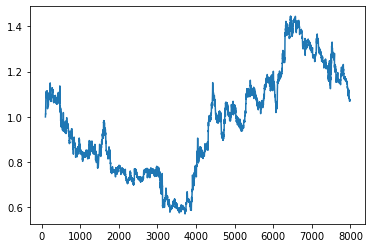

In [183]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [189]:
signals_df_validation.shape, X_validation_scaled.shape

((763, 12), (762, 8))

In [190]:
signals_df_validation = signals_df[signals_df.time > '2022-10-30']
signals_df_model2train = signals_df[signals_df.time < '2022-10-30']

In [191]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df_model2train[['Signal',
       'SMA_Fast4', 'SMA_Slow100', 'SMA_Fast3',
       'SMA_Slow50', 'EMA_5', 'EMA_4', 'EMA_3']].shift().dropna()

X_validation = signals_df_validation[['Signal',
       'SMA_Fast4', 'SMA_Slow100', 'SMA_Fast3',
       'SMA_Slow50', 'EMA_5', 'EMA_4', 'EMA_3']].shift().dropna()
# Create the target set selecting the Signal column and assiging it to y
y = signals_df_model2train['Signal'].iloc[1:,]
y_validation = signals_df_validation['Signal'].iloc[1:,]

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_validation_scaled = X_scaler.transform(X_validation)

In [193]:
# Initiate the model instance
model = LogisticRegression()

# Fit the model using the training data
model.fit(X_train, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test)
print(classification_report(y_true=y_test, y_pred=pred))

d = {k:v for k, v in zip(list(X.columns.values), model.coef_[0])}

{k: v for k, v in sorted(d.items(), key=lambda item: abs(item[1]), ) }

              precision    recall  f1-score   support

        -1.0       0.51      0.61      0.55      1151
         1.0       0.54      0.43      0.48      1199

    accuracy                           0.52      2350
   macro avg       0.52      0.52      0.52      2350
weighted avg       0.52      0.52      0.52      2350



{'SMA_Slow100': -6.056844336682091e-05,
 'Signal': -8.969181037958037e-05,
 'SMA_Slow50': 0.00013213555105010387,
 'EMA_5': 0.0008692528810224195,
 'EMA_4': -0.0008768131497430966,
 'EMA_3': -0.0008768131497430966,
 'SMA_Fast3': -0.001118234292761737,
 'SMA_Fast4': 0.001930368078383619}

In [194]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_validation.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = model.predict(X_validation_scaled)

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df_validation['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [195]:
catdf = pd.concat([(1 + predictions_df['Strategy Returns']).cumprod(), (1 + signals_df_validation['Actual Returns']).cumprod()], axis=1)
catdf.columns = ['Strategy Returns', "Actual Returns"]
hv.extension('bokeh')
catdf.hvplot()

Output hidden; open in https://colab.research.google.com to view.

In [196]:
signals_df = pd.read_csv("./data/dataBTCUSD2018today.csv", index_col=False)
signals_df.columns = ['time', 'close']

In [ ]:
signals_df["Actual Returns"] = signals_df["close"].pct_change()
signals_df = signals_df.dropna()
signals_df['Signal'] = 0.0
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

signals_df['SMA_Fast4'] = signals_df['close'].rolling(window=4).mean()
signals_df['SMA_Slow100'] = signals_df['close'].rolling(window=100).mean()

signals_df['SMA_Fast3'] = signals_df['close'].rolling(window=3).mean()
signals_df['SMA_Slow50'] = signals_df['close'].rolling(window=50).mean()

signals_df['SMA_Fast3'] = signals_df['close'].rolling(window=3).mean()
signals_df['SMA_Slow50'] = signals_df['close'].rolling(window=50).mean()

signals_df['EMA_5'] = signals_df['close'].ewm(span=5).mean()
signals_df['EMA_4'] = signals_df['close'].ewm(span=4).mean()
signals_df['EMA_3'] = signals_df['close'].ewm(span=4).mean()

signals_df = signals_df.dropna()

In [198]:
signals_df_validation = signals_df[signals_df.time > '2022-10-30']
signals_df_model2train = signals_df[signals_df.time < '2022-10-30']

In [199]:
X = signals_df_model2train[['Signal',
       'SMA_Fast4', 'SMA_Slow100', 'SMA_Fast3',
       'SMA_Slow50', 'EMA_5', 'EMA_4', 'EMA_3']].shift().dropna()
y = signals_df_model2train['Signal'].iloc[1:,]
y_validation = signals_df_validation['Signal'].iloc[1:,]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_validation_scaled = X_scaler.transform(X_validation)

model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(classification_report(y_true=y_test, y_pred=pred))


              precision    recall  f1-score   support

        -1.0       0.54      0.55      0.54      6755
         1.0       0.56      0.55      0.56      7132

    accuracy                           0.55     13887
   macro avg       0.55      0.55      0.55     13887
weighted avg       0.55      0.55      0.55     13887



In [200]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_validation.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = model.predict(X_validation_scaled)

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df_validation['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [202]:
catdf = pd.concat([(1 + predictions_df['Strategy Returns']).cumprod(), (1 + signals_df_validation['Actual Returns']).cumprod()], axis=1)

catdf.columns = ['Strategy Returns', "Actual Returns"]
hv.extension('bokeh')
catdf.hvplot()

Output hidden; open in https://colab.research.google.com to view.

In [172]:
catdf = (1 + predictions_df['Strategy Returns']).cumprod()

hv.extension('bokeh')
catdf.hvplot()

Output hidden; open in https://colab.research.google.com to view.